# Assignment 1B - Question 1
## Training and Adapting Deep Networks

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from scipy.io import loadmat

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook
from tensorflow.keras.preprocessing.image import Iterator

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



### Load data from training and testing sets

Use scipy.io loadmat function

In [2]:
train = loadmat('Data/Q1/q1_train.mat')
test = loadmat('Data/Q1/q1_test.mat')

### Sanity check

In [3]:
train['train_Y'].shape

(1000, 1)

In [4]:
test['test_Y'].shape

(10000, 1)

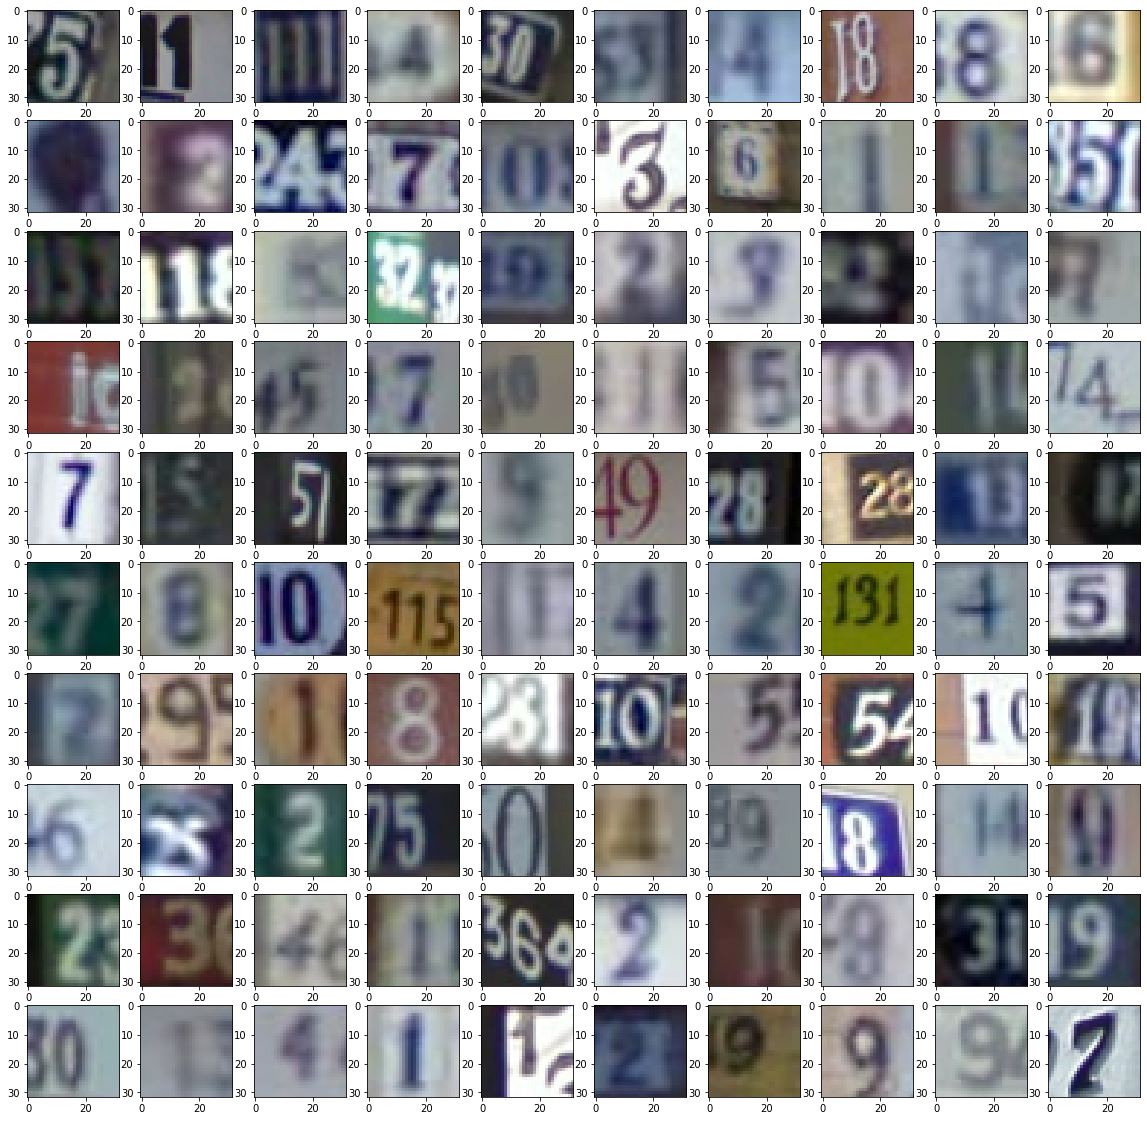

In [5]:
(x_test, y_test) = (test['test_X'], test['test_Y'])
x_test = x_test.astype('float32') / 255
x_test = np.transpose(x_test, (3,0,1,2))
fig = plt.figure(figsize=[20, 20])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(x_test[i,:,:,:])

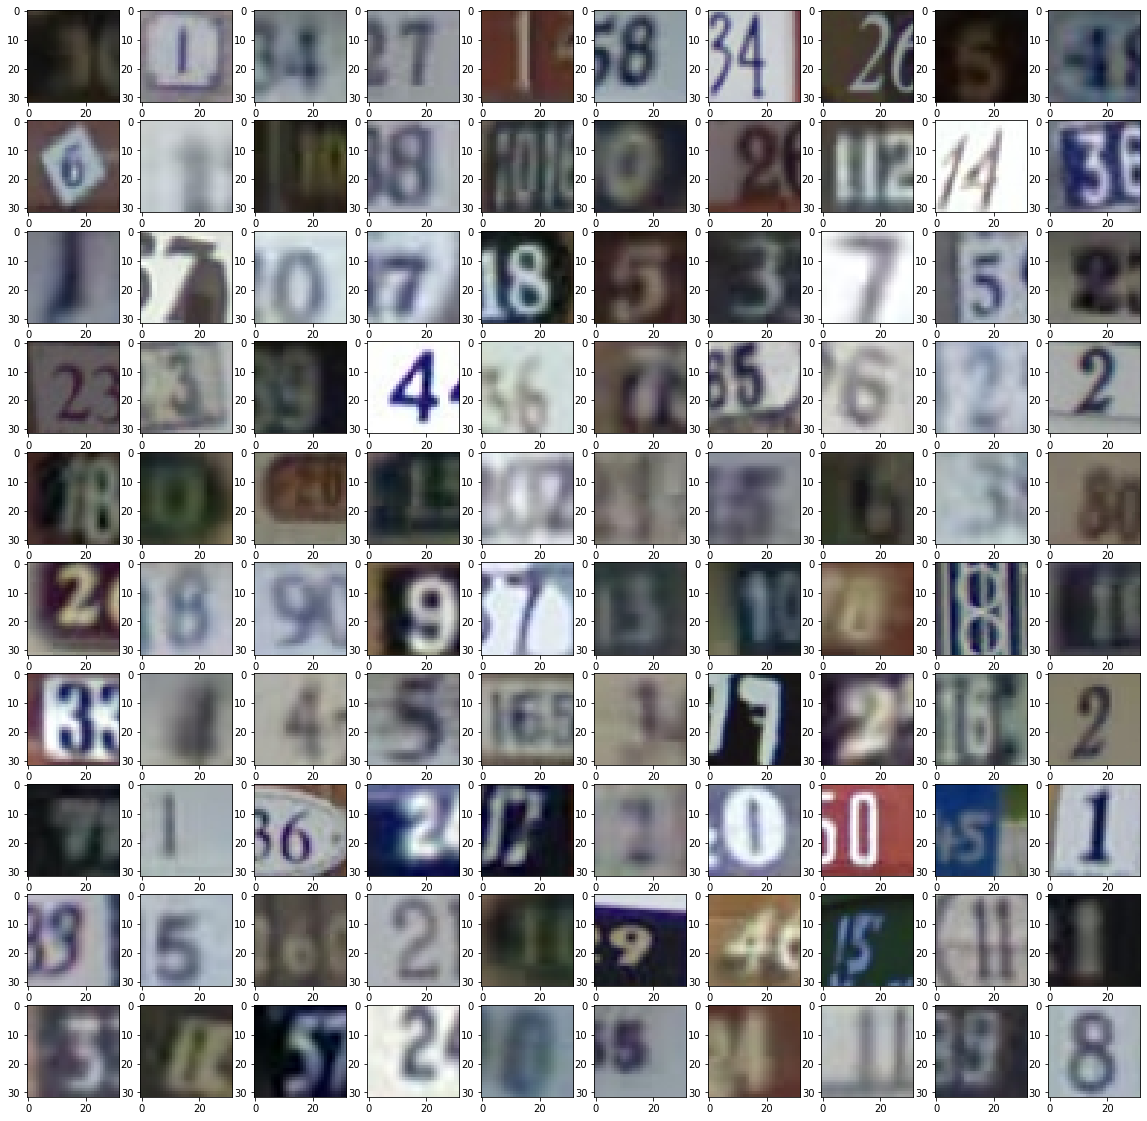

In [6]:
(x_train, y_train) = (train['train_X'], train['train_Y'])
x_train = x_train.astype('float32') / 255
x_train = np.transpose(x_train, (3,0,1,2))
fig = plt.figure(figsize=[20, 20])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(x_train[i,:,:,:])

### Keras Model

Taken from Week 4 example 2

In [7]:
def get_model():
    inputs = keras.Input(shape=(32, 32, 3, ), name='img')
    x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(11, activation='softmax')(x)

    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='SVHN_CNN_Model')
    
    return model_cnn

In [8]:
model_cnn = get_model()
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'])
history = model_cnn.fit(x_train, y_train,
                        batch_size=32,
                        epochs=10,
                        validation_split=0.2, verbose=True)

Epoch 1/10
25/25 [==============================] - 2s 61ms/step - loss: 2.3248 - accuracy: 0.1567 - val_loss: 2.2658 - val_accuracy: 0.1600
Epoch 2/10
25/25 [==============================] - 0s 20ms/step - loss: 2.2760 - accuracy: 0.1746 - val_loss: 2.2516 - val_accuracy: 0.1600
Epoch 3/10
25/25 [==============================] - 0s 16ms/step - loss: 2.2352 - accuracy: 0.1839 - val_loss: 2.2088 - val_accuracy: 0.1700
Epoch 4/10
25/25 [==============================] - 0s 14ms/step - loss: 2.2081 - accuracy: 0.2131 - val_loss: 2.1801 - val_accuracy: 0.1600
Epoch 5/10
25/25 [==============================] - 0s 14ms/step - loss: 2.1523 - accuracy: 0.2115 - val_loss: 2.1513 - val_accuracy: 0.2000
Epoch 6/10
25/25 [==============================] - 0s 14ms/step - loss: 2.0700 - accuracy: 0.2464 - val_loss: 2.1075 - val_accuracy: 0.2550
Epoch 7/10
25/25 [==============================] - 0s 14ms/step - loss: 1.9860 - accuracy: 0.2926 - val_loss: 2.0567 - val_accuracy: 0.2800
Epoch 8/10
25

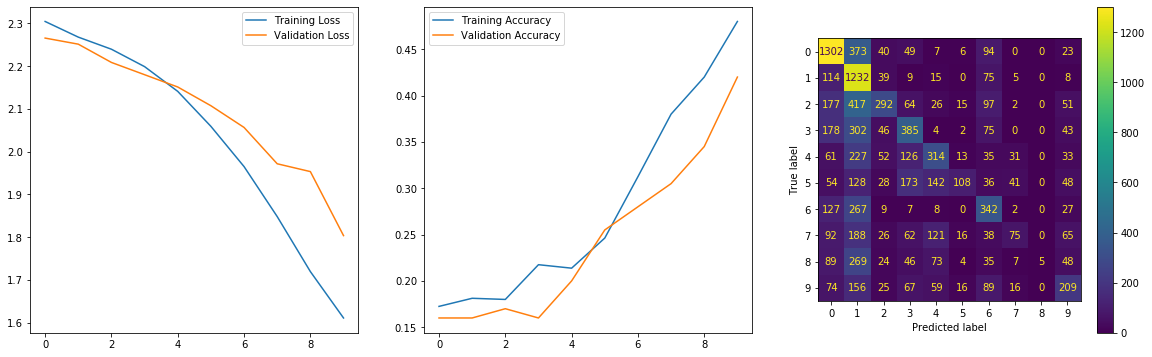

In [9]:
def plot_training(history, model, x_test, y_test):
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 3, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.legend()

    ax = fig.add_subplot(1, 3, 2)
    ax.plot(history.history['accuracy'], label="Training Accuracy")
    ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
    ax.legend();
    
    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    i = tf.cast([], tf.int32)
    indexes = tf.gather_nd(indexes, i)
    
    cm = confusion_matrix(y_test, indexes)
    ax = fig.add_subplot(1, 3, 3)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)
    
plot_training(history, model_cnn, x_test, y_test)

### Data Augmentation

Week 5 example 3

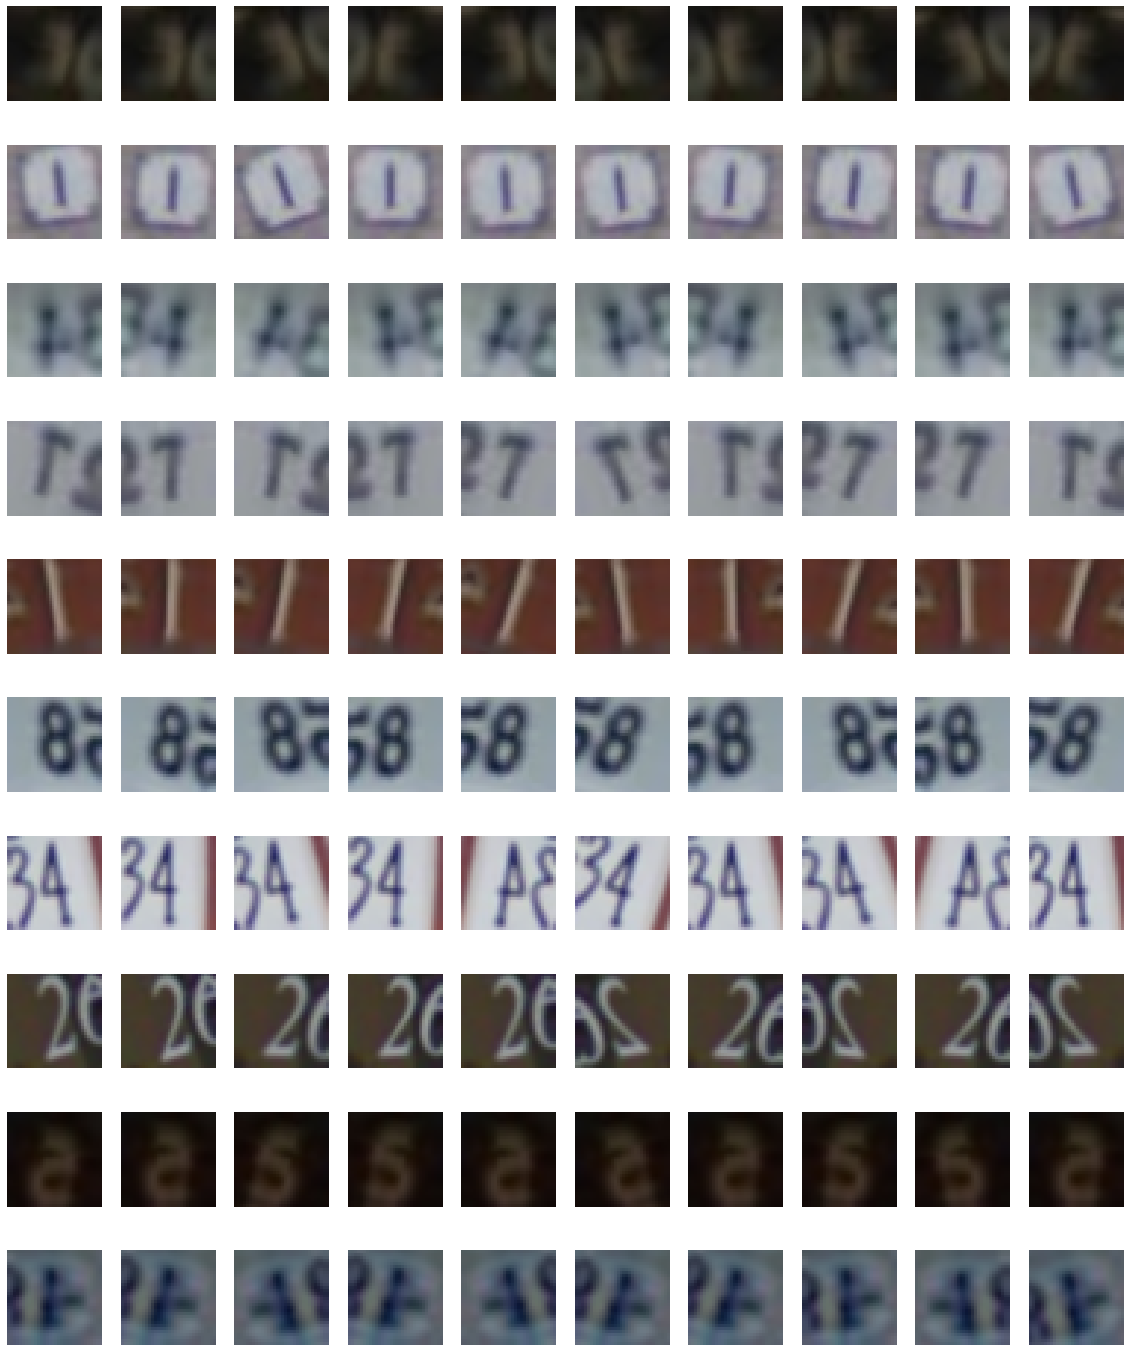

In [10]:
data_augmentation = keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.05),
  layers.experimental.preprocessing.RandomZoom(0.025),
  layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.025, 0.025), width_factor=(-0.025, 0.025))
])

fig = plt.figure(figsize=[20, 25])
for i in range(10):
    for j in range(10):
        ax = fig.add_subplot(10, 10, i*10 + (j + 1))
        augmented_image = data_augmentation(tf.expand_dims(x_train[i,:,:,:],0))
        plt.imshow(augmented_image[0])
        plt.axis("off")

In [11]:
def get_model_augment():
    inputs = keras.Input(shape=(32, 32, 3, ), name='img')
    augmented = data_augmentation(inputs)
    x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(augmented)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(11, activation='softmax')(x)

    model_cnn_aug = keras.Model(inputs=inputs, outputs=outputs, name='SVHN_CNN_Model')
    
    return model_cnn_aug

In [12]:
model_cnn_aug = get_model_augment()
model_cnn_aug.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'])
history = model_cnn_aug.fit(x_train, y_train,
                        batch_size=32,
                        epochs=10,
                        validation_split=0.2, verbose=True)

Epoch 1/10
25/25 [==============================] - 2s 31ms/step - loss: 2.3768 - accuracy: 0.1290 - val_loss: 2.2357 - val_accuracy: 0.2000
Epoch 2/10
25/25 [==============================] - 1s 21ms/step - loss: 2.2898 - accuracy: 0.1844 - val_loss: 2.2358 - val_accuracy: 0.1650
Epoch 3/10
25/25 [==============================] - 1s 28ms/step - loss: 2.2711 - accuracy: 0.1686 - val_loss: 2.2252 - val_accuracy: 0.1650
Epoch 4/10
25/25 [==============================] - 1s 21ms/step - loss: 2.2443 - accuracy: 0.1771 - val_loss: 2.2179 - val_accuracy: 0.1650
Epoch 5/10
25/25 [==============================] - 1s 20ms/step - loss: 2.2592 - accuracy: 0.1957 - val_loss: 2.2073 - val_accuracy: 0.2150
Epoch 6/10
25/25 [==============================] - 1s 20ms/step - loss: 2.2472 - accuracy: 0.1810 - val_loss: 2.2249 - val_accuracy: 0.1750
Epoch 7/10
25/25 [==============================] - 1s 21ms/step - loss: 2.2435 - accuracy: 0.1998 - val_loss: 2.2178 - val_accuracy: 0.2500
Epoch 8/10
25

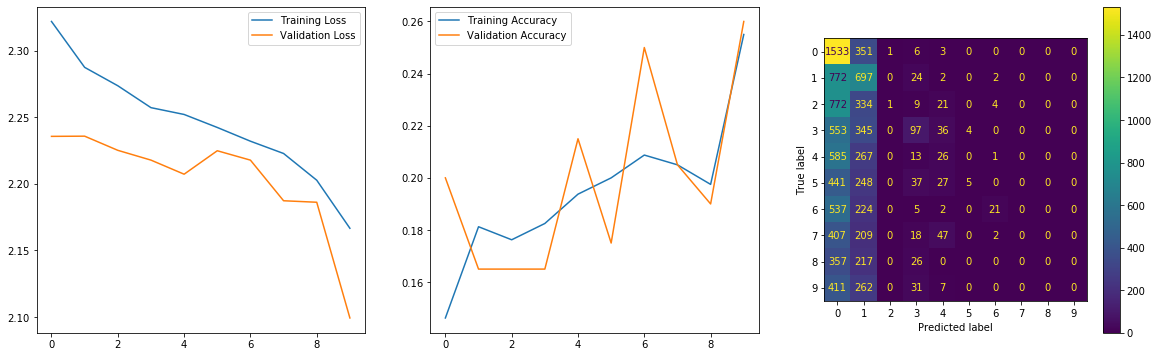

In [13]:
def plot_training(history, model, x_test, y_test):
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 3, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.legend()

    ax = fig.add_subplot(1, 3, 2)
    ax.plot(history.history['accuracy'], label="Training Accuracy")
    ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
    ax.legend()
    
    pred = model.predict(x_test)
    indexes = tf.argmax(pred, axis=1)
    i = tf.cast([], tf.int32)
    indexes = tf.gather_nd(indexes, i)
    
    cm = confusion_matrix(y_test, indexes)
    ax = fig.add_subplot(1, 3, 3)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)
    
plot_training(history, model_cnn_aug, x_test, y_test)


### Fine Tuning on vgg

Week 5 example 3


In [14]:
model = keras.models.load_model('vgg_2stage_CIFAR_bigger.h5')

x = layers.Dense(64, activation='relu')(model.layers[-6].output)
# output layer, single value, as we only have 1 output - the 
outputs = layers.Dense(11)(x)

new_model = keras.Model(inputs=model.input, outputs=outputs)
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_37 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
activation_37 (Activation)   (None, 32, 32, 16)        0         
_________________________________________________________________
spatial_dropout2d_22 (Spatia (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 16)        0     

In [15]:
# train the model
new_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'])

history = new_model.fit(x_train, y_train,
                        batch_size=64,
                        epochs=100,
                        validation_split=0.2, verbose=True)

Epoch 1/100
13/13 [==============================] - 4s 206ms/step - loss: 9.9330 - accuracy: 0.1049 - val_loss: 2.4434 - val_accuracy: 0.1000
Epoch 2/100
13/13 [==============================] - 2s 166ms/step - loss: 2.6821 - accuracy: 0.1205 - val_loss: 2.5120 - val_accuracy: 0.1200
Epoch 3/100
13/13 [==============================] - 2s 165ms/step - loss: 2.3863 - accuracy: 0.1229 - val_loss: 2.4424 - val_accuracy: 0.1200
Epoch 4/100
13/13 [==============================] - 2s 164ms/step - loss: 2.3965 - accuracy: 0.1128 - val_loss: 2.3859 - val_accuracy: 0.1150
Epoch 5/100
13/13 [==============================] - 2s 164ms/step - loss: 2.4333 - accuracy: 0.1079 - val_loss: 2.4409 - val_accuracy: 0.1200
Epoch 6/100
13/13 [==============================] - 2s 163ms/step - loss: 2.3918 - accuracy: 0.0896 - val_loss: 2.3859 - val_accuracy: 0.1350
Epoch 7/100
13/13 [==============================] - 2s 188ms/step - loss: 2.3809 - accuracy: 0.1094 - val_loss: 2.3859 - val_accuracy: 0.1300